In [20]:
import sys
# !{sys.executable} -m pip install seaborn
from glob import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
function_dict={'quad16qubit':'Quadratic','lin16qubit':'Linear','sin16qubit':'Sine'}

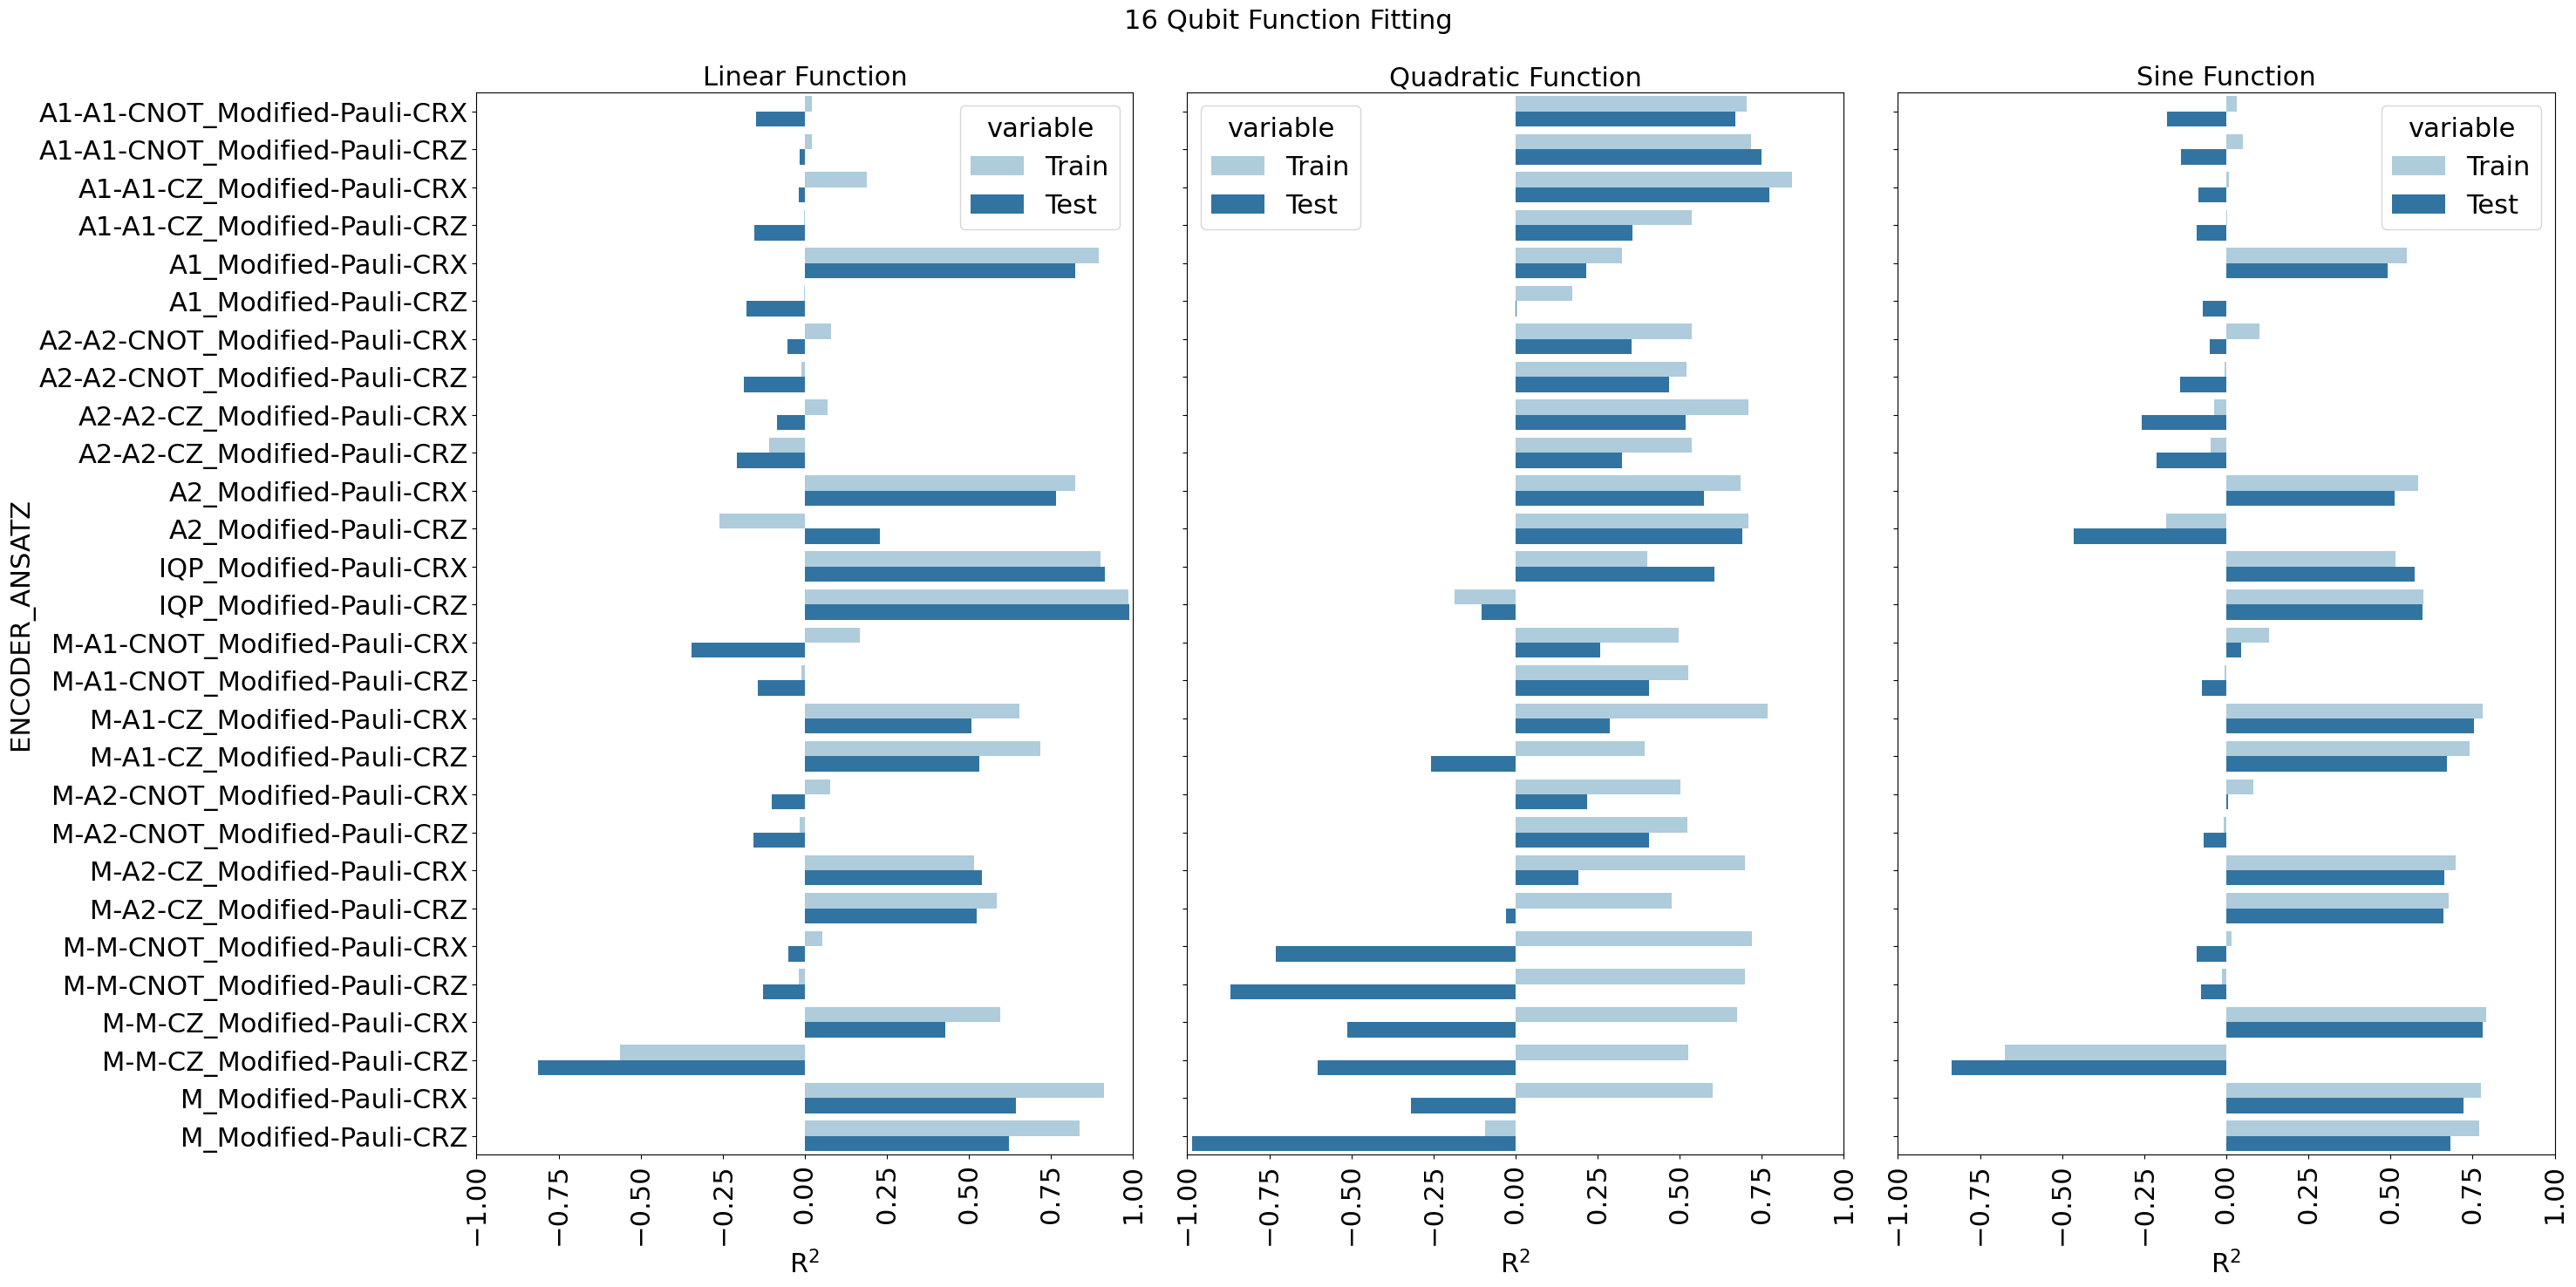

In [9]:
fig,ax = plt.subplots(1,3,figsize=(30,15),sharey=True)
SMALL_SIZE = 8
MEDIUM_SIZE = 22
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f'function-calc-test/sixteenqubit_test/{k}/*/*results.json'):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'})
    sns.barplot(data=r2_df.reset_index().melt(id_vars='index'),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx])
    ax[idx].set_xlabel('R$^{2}$')
    ax[idx].set_ylabel('ENCODER_ANSATZ')
    ax[idx].set_title(f"{v} Function")
    ax[idx].tick_params(axis='x', labelrotation=90)
    ax[idx].set_xlim(-1,1)
fig.suptitle('16 Qubit Function Fitting')
plt.tight_layout()
plt.savefig('16qubit_funcfit_R2.png',dpi=300,bbox_inches='tight')
plt.show()

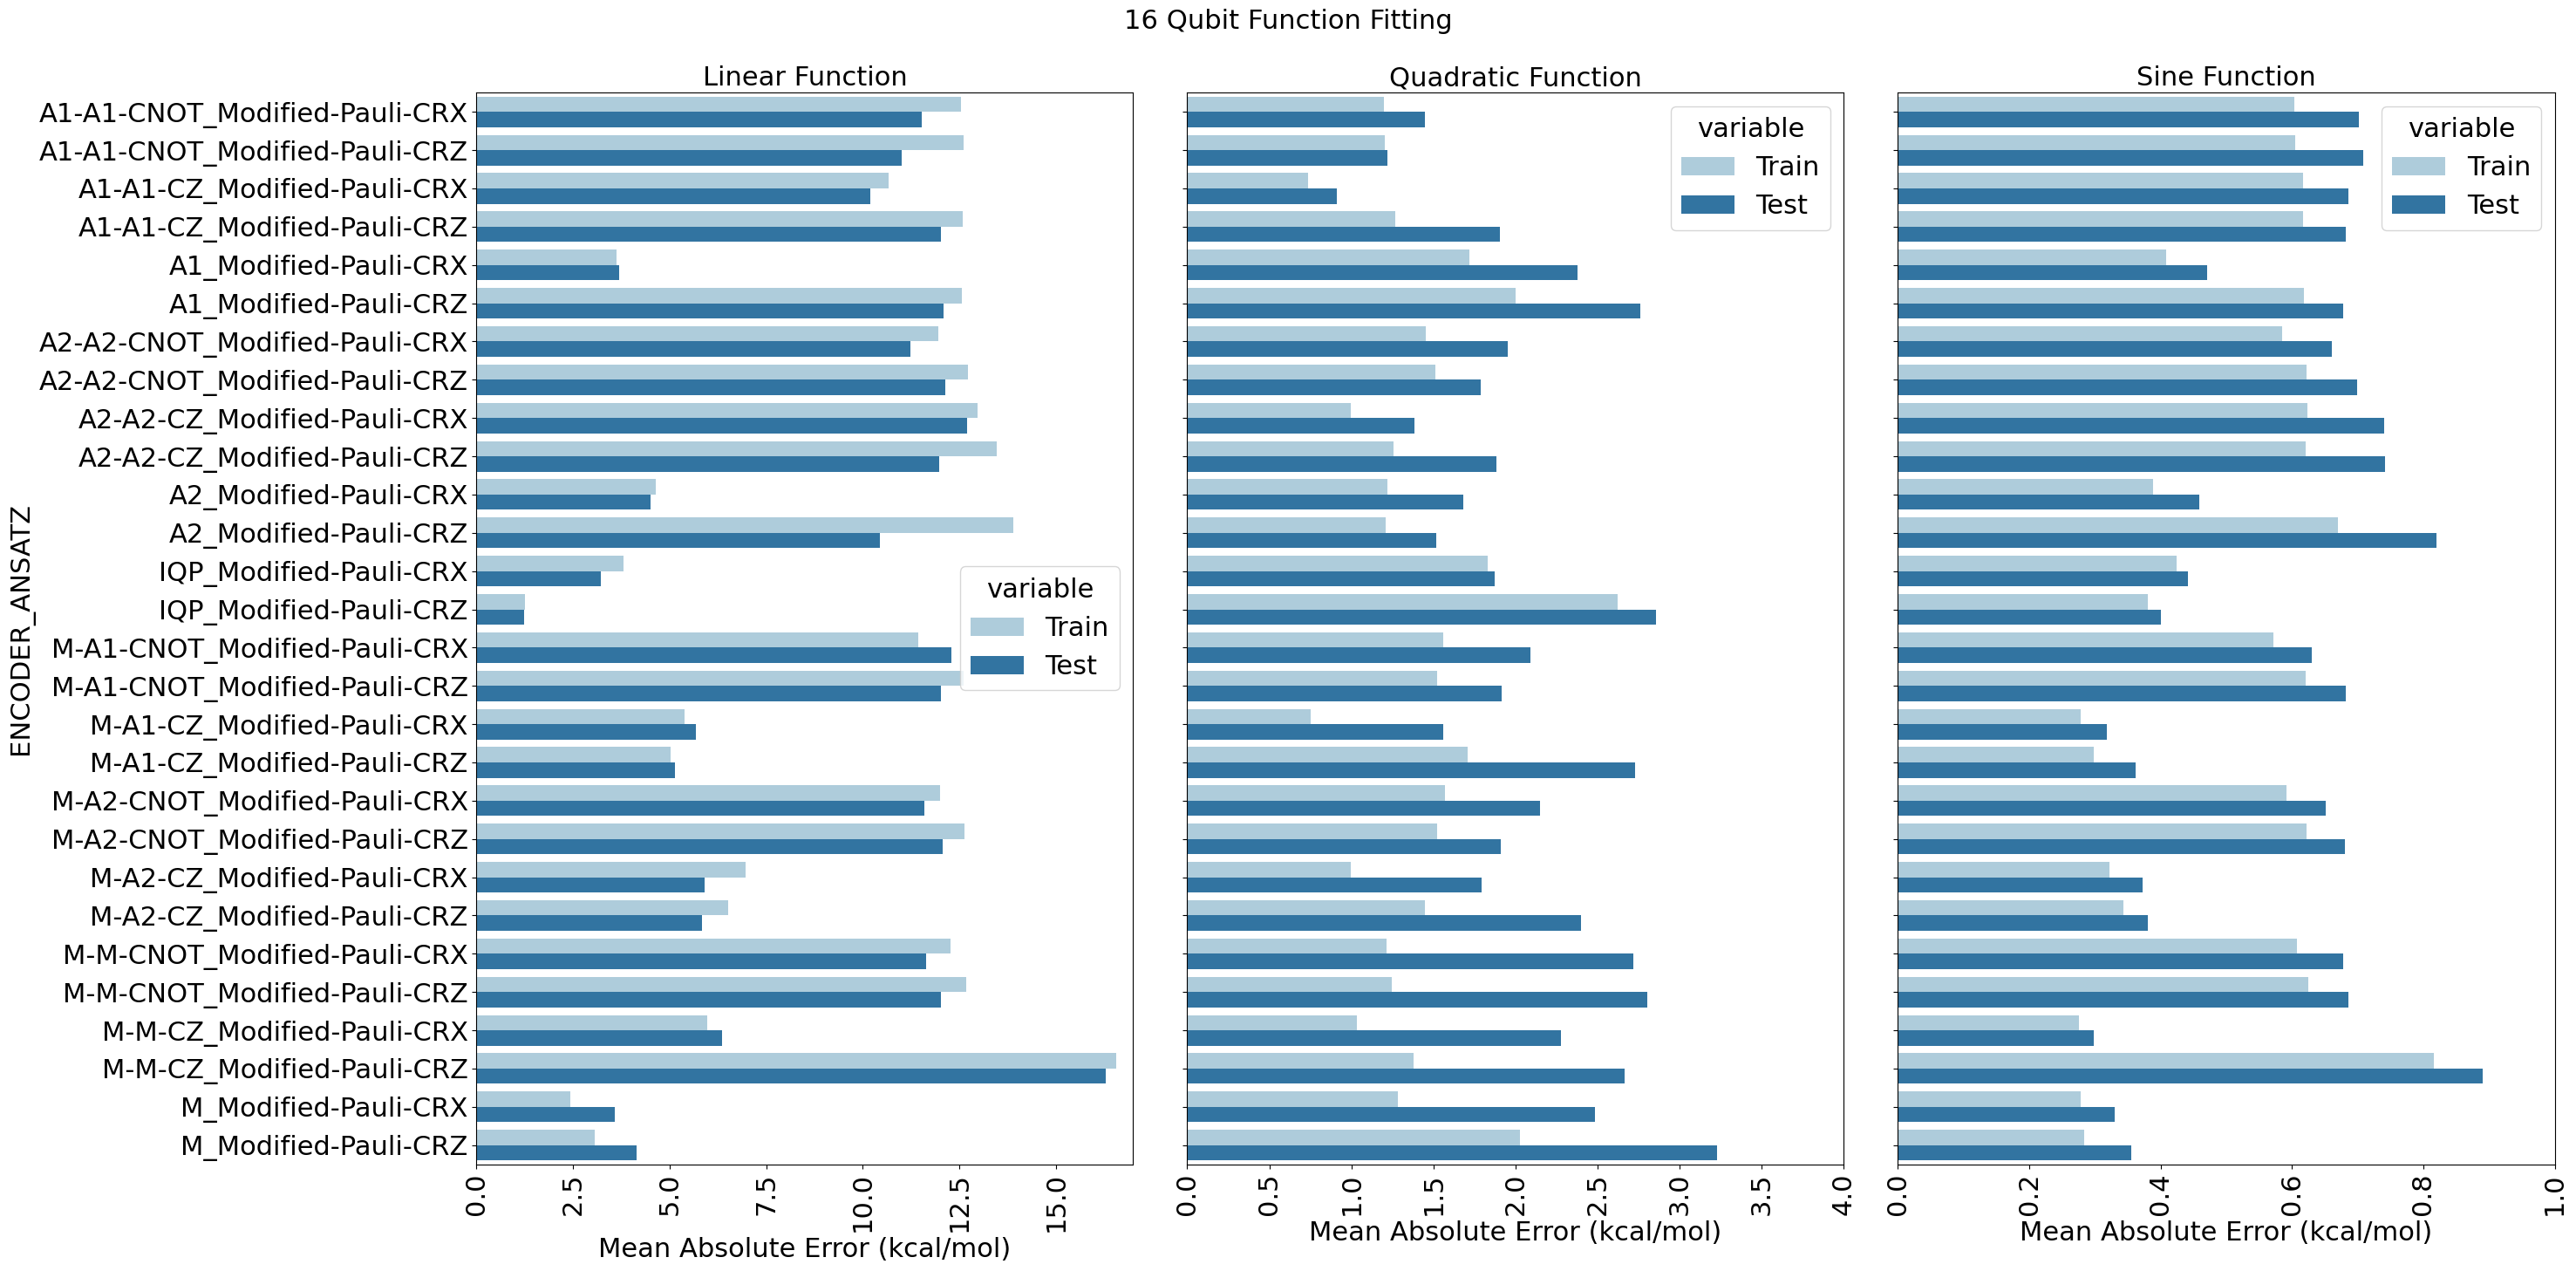

In [23]:
fig,ax = plt.subplots(1,3,figsize=(30,15),sharey=True)
SMALL_SIZE = 8
MEDIUM_SIZE = 22
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f'function-calc-test/sixteenqubit_test/{k}/*/*results.json'):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    MAE_df=pd.DataFrame.from_dict(results).T[['MAE_train','MAE_test']].sort_index().rename(columns={'MAE_train':"Train",'MAE_test':'Test'})
    
    sns.barplot(data=MAE_df.reset_index().melt(id_vars='index'),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx])
    ax[idx].set_xlabel('Mean Absolute Error (kcal/mol)')
    ax[idx].set_ylabel('ENCODER_ANSATZ')
    ax[idx].set_title(f"{v} Function")
    ax[idx].tick_params(axis='x', labelrotation=90)
    ax[idx].set_xlim(0,np.ceil(MAE_df.max().max()).astype(int))
fig.suptitle('16 Qubit Function Fitting')
plt.tight_layout()
plt.savefig('16qubit_funcfit_MAE.png',dpi=300,bbox_inches='tight')
plt.show()